<a href="https://colab.research.google.com/github/PranjalKushwaha/Un-Clear_Assignments/blob/main/Image_Colorisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
print(tf.__version__)
import time
import keras
import os
import matplotlib.pyplot as plt
print(keras.__version__)


2.5.0
2.5.0


In [ ]:
#from google.colab import files
#files.upload() 
#!pip install -q kaggle
#!mkdir -p ~/.kaggle
#!cp kaggle.json ~/.kaggle/
#!ls ~/.kaggle
#!chmod 600 /root/.kaggle/kaggle.json 

In [ ]:
#!kaggle datasets download --force -d ktaebum/anime-sketch-colorization-pair -p /content/drive/My\ Drive

In [ ]:
PATH ='/content/drive/My Drive/kaggle/Anime/unzipped3/data'
EPOCHS = 20
BUFFER_SIZE = 8000
BATCH_SIZE = 4
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
!unzip "/content/drive/My Drive/anime-sketch-colorization-pair.zip" -d "/content/drive/My Drive/kaggle/Anime/unzipped3"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/My Drive/kaggle/Anime/unzipped3/data/train/2906115.png  
  inflating: /content/drive/My Drive/kaggle/Anime/unzipped3/data/train/2906116.png  
  inflating: /content/drive/My Drive/kaggle/Anime/unzipped3/data/train/2906119.png  
  inflating: /content/drive/My Drive/kaggle/Anime/unzipped3/data/train/2906139.png  
  inflating: /content/drive/My Drive/kaggle/Anime/unzipped3/data/train/2906140.png  
  inflating: /content/drive/My Drive/kaggle/Anime/unzipped3/data/train/2906141.png  
  inflating: /content/drive/My Drive/kaggle/Anime/unzipped3/data/train/2906143.png  
  inflating: /content/drive/My Drive/kaggle/Anime/unzipped3/data/train/2907043.png  
  inflating: /content/drive/My Drive/kaggle/Anime/unzipped3/data/train/2907052.png  
  inflating: /content/drive/My Drive/kaggle/Anime/unzipped3/data/train/2907059.png  
  inflating: /content/drive/My Drive/kaggle/Anime/unzipped3/data/train/2907062.png  
  inflating: /

In [ ]:
def load(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_image(image,expand_animations = False)
    w = tf.shape(image)[1]
    w = w//2
    real_image = image[:,:w,:]
    input_image = image[:,w:,:]
    real_image = tf.cast(real_image,tf.float32)
    input_image = tf.cast(input_image,tf.float32)
    return input_image,real_image

In [ ]:

def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

In [ ]:
def random_crop(input_image,real_image):
    stack = tf.stack([input_image,real_image],axis=0)
    cropped = tf.image.random_crop(stack, size=[2,256,256,3])
    return cropped[0],cropped[1]

In [ ]:
def normalize(input_image, real_image):
    input_image = input_image/127.5 -1
    real_image = real_image/127.5 -1
    return input_image, real_image

In [ ]:
@tf.function()
def random_jitter(input_image, real_image):
    input_image, real_image = resize(input_image,real_image,286,286)
    input_image, real_image = random_crop(input_image,real_image)
    
    if tf.random.uniform(())>0.5:
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)
        
    return input_image, real_image

In [ ]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [ ]:
train_dataset = tf.data.Dataset.list_files(PATH+"/train/*.png")
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def load_image_test(file_path):
    input_image, real_image = load(file_path)
    input_image, real_image = resize(input_image, real_image,256,256)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

test_dataset = tf.data.Dataset.list_files(PATH+"/val/*.png")
test_dataset = test_dataset.map(load_image_test,num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)

Generator 

In [ ]:
OUTPUT_CHANNELS = 3
def downsample(filters,size,shape,batch_norm = True):
    initializer = tf.random_normal_initializer(0.0,0.02)
    result = tf.keras.Sequential();
    result.add(tf.keras.layers.Conv2D(filters, size, strides = 2, 
                                   padding = 'same', 
                                   batch_input_shape = shape,
                                   kernel_initializer=initializer,
                                   use_bias=False))
    if batch_norm:
        result.add(tf.keras.layers.BatchNormalization());
    
    result.add(tf.keras.layers.LeakyReLU())
    
    return result

def upsample(filters, size, shape,dropout = False):
    initializer = tf.random_normal_initializer(0.0,0.02)
    result = tf.keras.Sequential();
    result.add(tf.keras.layers.Conv2DTranspose(filters,size,
                                           strides = 2,
                                           padding = 'same',
                                           batch_input_shape = shape,
                                           kernel_initializer = initializer,
                                           use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

In [ ]:
def buildGenerator():
    inputs = tf.keras.layers.Input(shape = [256,256,3])
    down_stack=[
        downsample(64,4,(None,256,256,3), batch_norm = False),
        downsample(128,4,(None,128,128,64)),
        downsample(256,4,(None,64,64,128)),
        downsample(512,4,(None,32,32,256)),
        downsample(512,4,(None,16,16,512)),
        downsample(512,4,(None,8,8,512)),
        downsample(512,4,(None,4,4,512)),
        downsample(512,4,(None,2,2,512))
    ]
    
    up_stack = [
        upsample(512,4,(None,1,1,512),dropout = True),
        upsample(512,4,(None,2,2,1024),dropout = True),
        upsample(512,4,(None,4,4,1024),dropout = True),
        upsample(512,4,(None,8,8,1024)),
        upsample(256,4,(None,16,16,1024)),
        upsample(128,4,(None,32,32,512)),
        upsample(64,4,(None,64,64,256))
    ]
    
    initializer = tf.random_normal_initializer(0.0,0.02)
    
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS,4,
                                       strides = 2,
                                       padding = 'same',
                                       kernel_initializer=initializer,
                                       activation = 'tanh')
    
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
        
    skips = reversed(skips[:-1])
    
    for up,skip in zip(up_stack,skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x,skip])
        
    x = last(x)
    
    return tf.keras.Model(inputs = inputs,outputs = x)

generator = buildGenerator()

In [ ]:
def downs(filters,size,batch_norm = True):
    initializer = tf.random_normal_initializer(0.0,0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters,size,
                                     strides = 2,
                                     padding = 'same',
                                     kernel_initializer = initializer,use_bias = False))
    
    if batch_norm:
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.LeakyReLU())
    
    return result

def buildDiscriminator():
    initializer = tf.random_normal_initializer(0.0,0.02)
    inp = tf.keras.layers.Input(shape = [256,256,3],name = 'input_image')
    tar = tf.keras.layers.Input(shape = [256,256,3],name = 'target_image')
    
    x = tf.keras.layers.concatenate([inp, tar])
    
    down1 = downs(64,4,False)(x)
    down2 = downs(128,4)(down1)
    down3 = downs(256,4)(down2)
        
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv = tf.keras.layers.Conv2D(512,4,strides = 1,kernel_initializer = initializer,
                                 use_bias = False)(zero_pad1)
    
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
    last = tf.keras.layers.Conv2D(1,4,strides = 1,kernel_initializer = initializer)(zero_pad2)
    
    return tf.keras.Model(inputs = [inp,tar],outputs = last)

discriminator = buildDiscriminator()
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
target_image (InputLayer)       [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_image[0][0]                
                                                                 target_image[0][0]               
__________________________________________________________________________________________________
sequential_15 (Sequential)      (None, 128, 128, 64) 6144        concatenate_7[0][0]        

In [ ]:
loss_object = tf.losses.BinaryCrossentropy(from_logits=True)

LAMBDA = 100

def generator_loss(disc_generated_output,gen_output,target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output),disc_generated_output)
    
    l1_loss = tf.reduce_mean(tf.abs(target-gen_output))
    total_gen_loss = gan_loss +(LAMBDA*l1_loss)
    
    return total_gen_loss,gan_loss,l1_loss

def discriminator_loss(disc_real_output,disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output),disc_real_output)
    
    generated_loss = loss_object(tf.zeros_like(disc_generated_output),disc_generated_output)
    
    total_disc_loss = generated_loss + real_loss
    return total_disc_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)

In [ ]:
checkpoint_dir = '/content/drive/My Drive/kaggle'
checkpoint_prefix = os.path.join(checkpoint_dir, "checkpoint")

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,generator=generator,
                                 discriminator=discriminator)

In [ ]:
def generate_images(model,test_input,tar):
    prediction = model(test_input,training = True)
    plt.figure(figsize = (15,15))
    
    display_list= [test_input[0],tar[0],prediction[0]]
    title = ['Input image', 'Ground image', 'Predicted image']
    
    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.title(title[i])
        plt.imshow(display_list[i]*0.5+0.5)
        plt.axis('off')
    plt.show()

In [ ]:
import datetime
log_dir="/content/drive/My Drive/kaggle"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(input_image,target,epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image,training = True)
        disc_real_output = discriminator([input_image,target],training = True)
        disc_generated_output = discriminator([input_image,gen_output], training = True)
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output,gen_output,target)
        disc_loss = discriminator_loss(disc_real_output,disc_generated_output)
    generator_gradients = gen_tape.gradient(gen_total_loss,generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))
    
    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss',gen_total_loss,step = epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [ ]:
def fit(train_ds,epochs,test_ds):
    for epoch in range(epochs):
        start = time.time()
        for example_input, example_target in test_ds.take(1):
            generate_images(generator,example_input,example_target)
        print("Epoch: ",epoch)
        
        for n,(input_image,target) in train_ds.enumerate():
            print('.',end = '')
            if (n+1)%100==0:
                print()
            train_step(input_image,target,epoch)
        print()
        if (epoch+1)%5==0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            
        print('Time taken for epoch {} is {} sec\n'.format(epoch+1,time.time()-start))
    checkpoint.save(file_prefix =checkpoint_prefix)

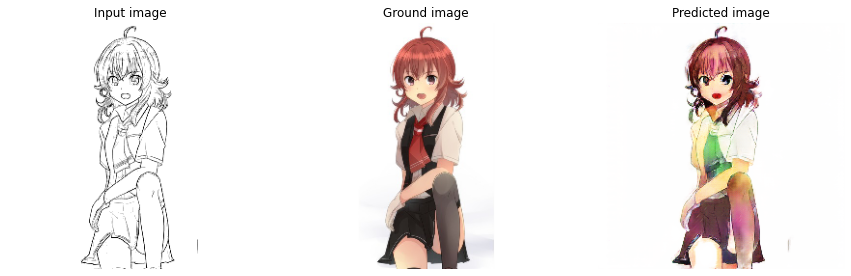

Epoch:  0
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................................................................

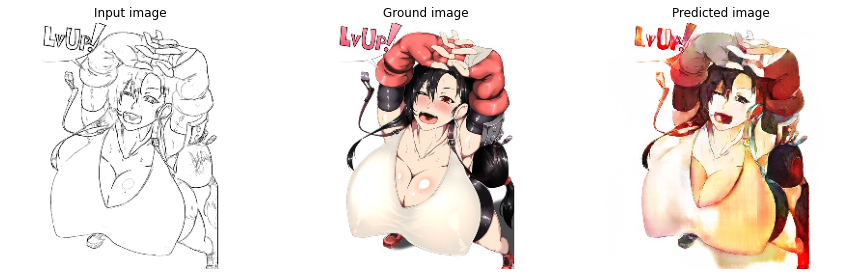

Epoch:  1
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................................................................

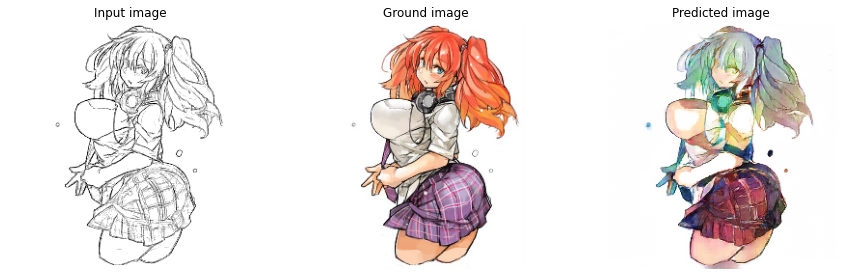

Epoch:  2
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................................................................

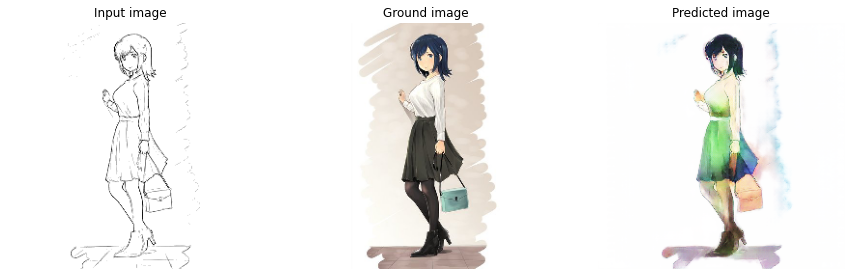

Epoch:  3
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................................................................

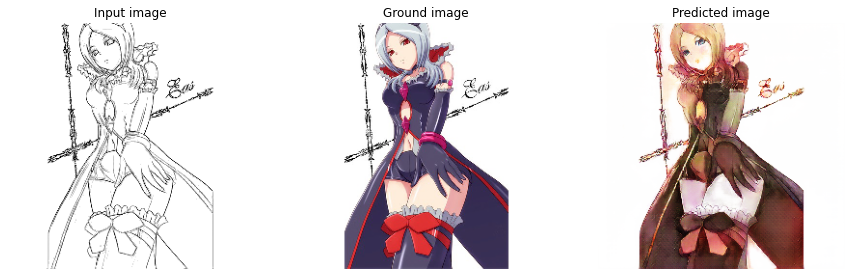

Epoch:  4
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................................................................

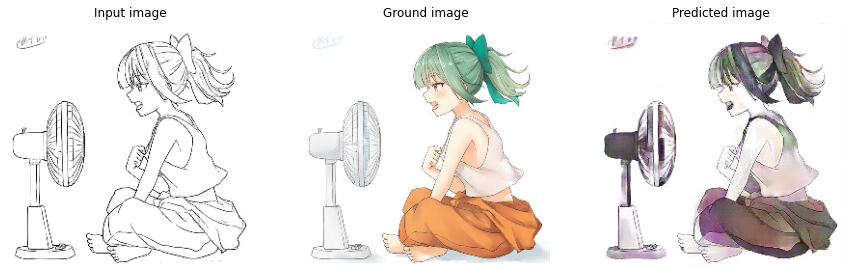

Epoch:  5
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................................................................

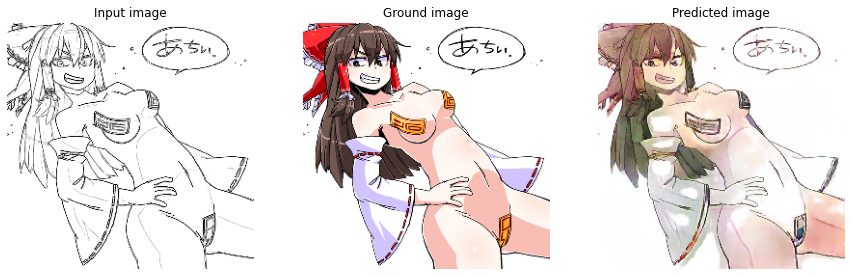

Epoch:  6
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................................................................

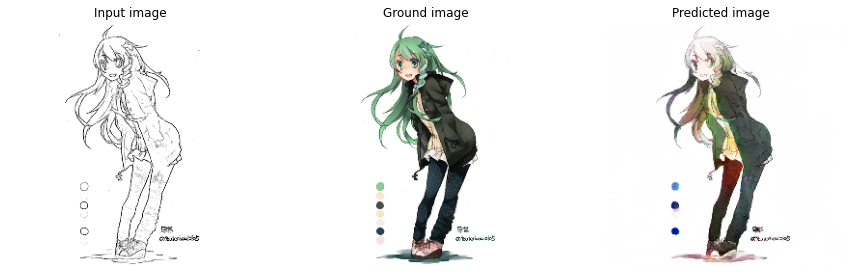

Epoch:  7
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................................................................

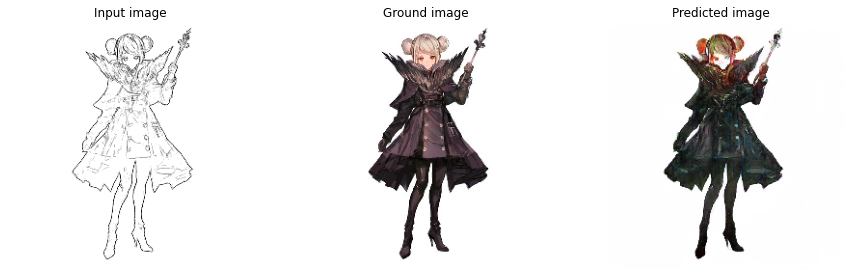

Epoch:  8
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................................................................

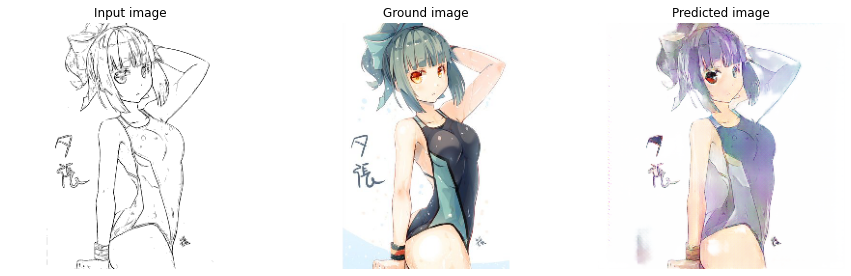

Epoch:  9
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................................................................

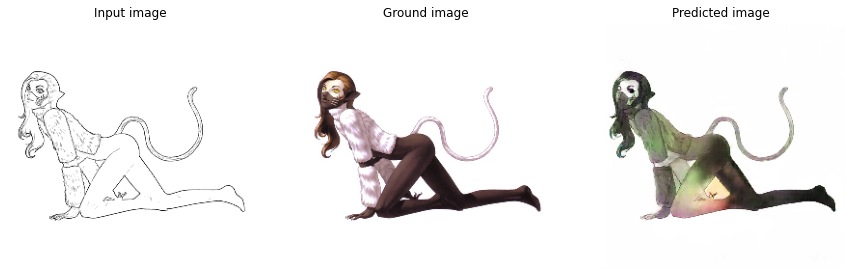

Epoch:  10
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
................................................................................

In [ ]:
fit(train_dataset,EPOCHS,test_dataset)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
model.checkpoint()
